# Multi-model Car Reservation Prediction 

# Overview
This is both a machine scalability (Docker+Flask+Guicorn+Kubernetes), and modeling (regression and classification) project which makes it very fun to work on proof of concepts. 

The data are real and requires feature preprocessing with EDA and importance study. The goal is to predict the number of reservations of vehicles (number of unique reservations per vehicle (non-negative numeric) and reservation type (categorical)) using the input features. The two targets makes this a multi-target regression and classification problem. 

For the modelling part, I explored the traditional ML tools (Tree, Boosting, SVM, Logistic ridge/lass/elasticNet), and built a multi-target deep neural network in the end with an independent sigmoid output layer for the categorical output with categorical cross-entropy loss, and a ReLU linear regression output layer for the non-negative numeric variable with MSE loss.

Finally I've deployed the model to a scalable asynchronous environment using `Docker`, `Flask-RESTFul`, `Gunicorn` on `Kubernetes` to perform http API call on the DNN model service.

What's learned?
* Horizonally scalable Dockerized asychronous RESTful web service on Kubernetes.
* Exploring feature space with `pairplot`, `Corrplot` heat map, `violinplot`, histogram, scatter, box, PCA, cosine similarity with bootstrapping and colinearity with VIF and chi-squared test.
* Feature selection/reduction using `Pipeline` and `GridSearchCV`
* Feature importance using `RFE` and coefficient ranking
* Feature engineering, replace a categorical variable by the number of times it appears in the train set turning it into a single feature.
* Encoding for nominal features (OneHot, Hashing, LeaveOneOut, and Target). OneHot is too expensive for high cardinality columns and decision tree-based algorithms.
* Trees (Decision tree, Random Forest, `XGBoost`) and GLMs performs better than DNN, which has more complexity but suffers from overfitting!
* Reduce imbalanced classes by `SMOTE`, upsampling/downsampling, and class/sample weighting
* Reducing colinearity with standarization and models: PCA, Lasso, Ridge, and Elastic Net regression
* Building dual-branched (either branch at input or output layer) DNN by utilizing both categorical loss and numerical loss
* Comparing benchmark models: SVM with RBF kernel, softmax regression, multilinear regression
* log likelihood ratio test for logistic regression

My math notebooks ([XGBoost](https://github.com/ginochen/ML_notes/blob/master/XGBoost.ipynb), [support vector machine](https://github.com/ginochen/ML_notes/blob/master/support_vector_machine.ipynb), [logistic regression](https://github.com/ginochen/ML_notes/blob/master/logistic_regression_cross_entropy.ipynb), [stochastic gradient descent](https://github.com/ginochen/ML_notes/blob/master/stochastic_gradient_descent.ipynb)) for the ML tools used in this project serve as reminders of what's really happening algorithmically in the python packages.

# Outline
* Feature EDA
* Feature selection/reduction
* Feature importance
* Model training 
* Multi-model intercomparison
* Prediction metrics and analysis
* Feature interpretation
* Dockerized scalable web API model service

Note: all help functions are appended to the end of the project.


# Data 
Due to confidentiality issues of the data, I won't disclose the source of the data. Let's begin by importing

In [14]:
df_vehicles = pd.read_csv('./vehicles.csv')
df_reservations = pd.read_csv('./reservations.csv')

In [488]:
df_vehicles.columns[1:]

Index(['is_delivery', 'actual_price', 'recommended_price', 'num_images',
       'description_length', 'is_recent_model'],
      dtype='object')

In [365]:
print('VEHICLES\n =============================================== \n',df_vehicles[['is_delivery', 'actual_price', 'recommended_price', 'num_images', 'description_length',  'is_recent_model']].head(4))
print('\nRESERVATIONS\n ========================================== \n',df_reservations[['reservation_id',  'reservation_type']].head(4))

VEHICLES
    is_delivery  actual_price  recommended_price  num_images  \
0            1            89                 94           2   
1            1            33                 42          12   
2            0            62                 60           8   
3            1           195                204           7   

   description_length  is_recent_model  
0                  74                0  
1                   0                0  
2                   0                0  
3                   0                1  

RESERVATIONS
    reservation_id  reservation_type
0       2677903.0               2.0
1       2752124.0               2.0
2       2780924.0               2.0
3       2798489.0               2.0


In [16]:
df = pd.merge(df_reservations,df_vehicles, how='inner', on='vehicle_id') # join on intersection on vehicle_id
tmp = df.groupby('vehicle_id').reservation_id.nunique().to_frame()
tmp.columns = ["n_reserve"] # rename the column to number of reservations for each unique vehicle ID
df = pd.merge(df,tmp,how='inner',on='vehicle_id')

In [17]:
print('(samples, columns) = %s'%str(df.shape))
print('max description length = %s'%str(df.description_length.max()))

(samples, columns) = (195243, 10)
max description length = 7780


Let's checkout the feature space

In [333]:
nrows = df.shape[0]

#df = df.dropna(axis=0) # drop NaNs
#x = df.iloc[:, [2,4,5,8]].values
df_x = df[['is_delivery','actual_price','recommended_price','num_images','description_length','is_recent_model']]
print('x = \n%s'%str(df_x.iloc[0]))
# change categorical type to str for "pairplot" to use as "hue"
df_plot = pd.concat([pd.DataFrame(df['reservation_type'].astype(str)),df_x],axis=1,sort=False)

x = df_x.values # skip is_delivery since it's the tag
y_num = df['n_reserve'].values # the tag to color mark on projected features
y_cat = df['reservation_type'].values
y_cat[np.isnan(y_cat)]=0
lb = preprocessing.LabelBinarizer()
y_catx = lb.fit_transform(y_cat) # binarizer transformed y_cat into [nsamples,n_cats] matrix, do this once and use .transform() later
print('\ny_num: \nnumber of reservation = %s \n\ny_cat: \nreservation_type = %s'%(str(y_num),str(set(y_cat))))
print('\ny_catx: reservation_type binarized = %s'%str(y_catx[:2,:]))

x = 
is_delivery             0
actual_price          121
recommended_price      48
num_images              9
description_length      0
is_recent_model         0
Name: 0, dtype: int64

y_num: 
number of reservation = [ 2  2 11 ...  0  0  0] 

y_cat: 
reservation_type = {0.0, 1.0, 2.0}

y_catx: reservation_type binarized = [[0 0 1]
 [0 0 1]]


In [19]:
# mean, median, max, min, std, 25%, 50%, 70%
dfstats = df.describe()
#--- memory consumed by dataframe ---
mem = df.memory_usage(index=True).sum()
print("Memory consumed by data set  :   {} MB" .format(mem/ 1024**2))
change_datatype_float(df)
mem = df.memory_usage(index=True).sum()
print("Memory consumed by data set after converting float64 to float32 :   {} MB" .format(mem/ 1024**2))
print('\n')

Memory consumed by data set  :   21.38544464111328 MB
Memory consumed by data set after converting float64 to float32 :   19.895858764648438 MB




## Feature EDA

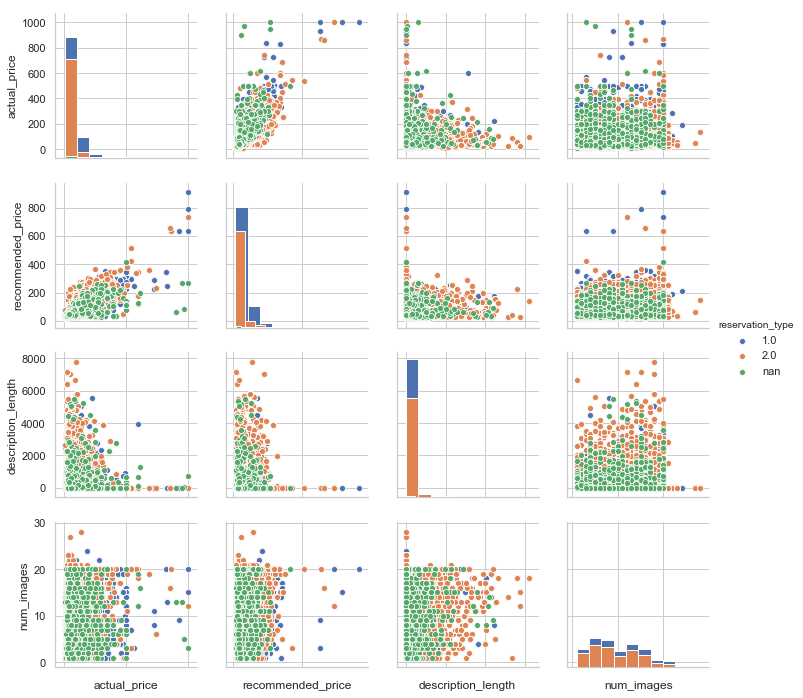

percentage and number of NaNs in reservation_id = 0.69% and 1355
Show the reservation_id with NaN (black) and values (white)


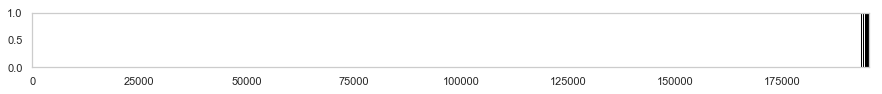

Correlation matrix visualized between numeric variables


/usr/local/lib/python3.5/site-packages/pyensae/graphhelper/linkage.py:43: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



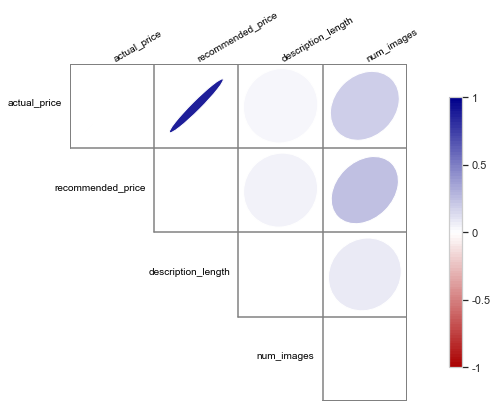

Chi squared test of is_recent_model and is_delivery
The two cat variables has chi^2 stats of 1320.1291614900167 and p-val of 6.312069357295463e-286
The two cat variables are significantly dependent
Chi squared test for all features
[2.43987016e+01 3.01702539e+05 2.18551974e+05 1.34914876e+03
 1.58241840e+05 4.44709854e+02] [5.03372254e-006 0.00000000e+000 0.00000000e+000 1.08659629e-293
 0.00000000e+000 2.70696246e-097]


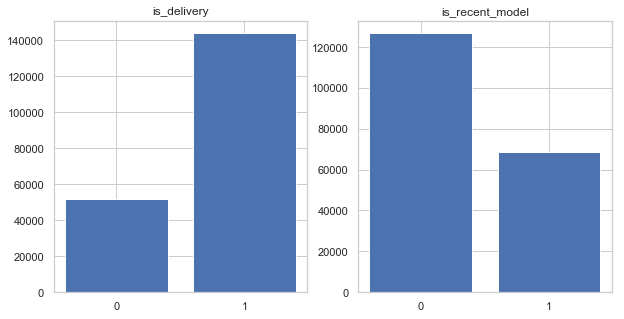

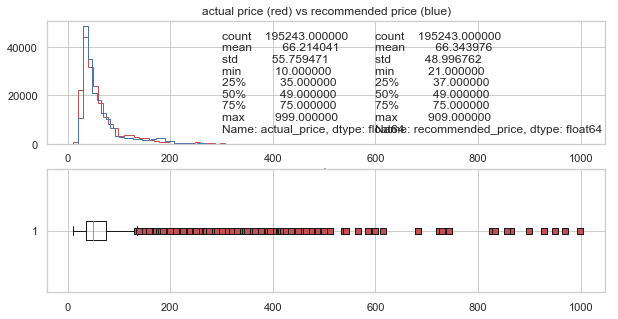

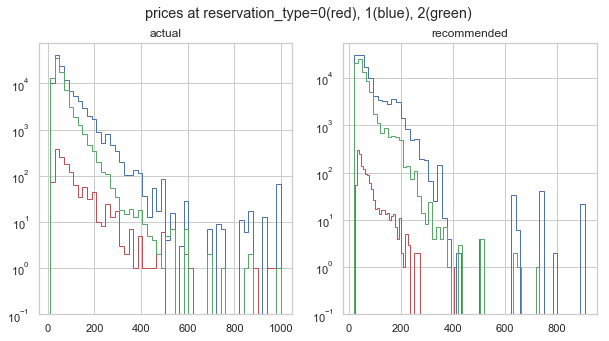

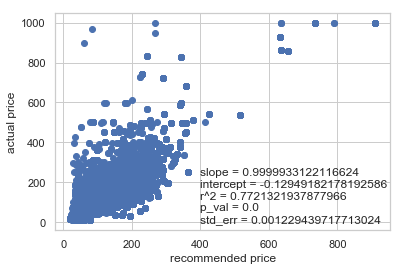

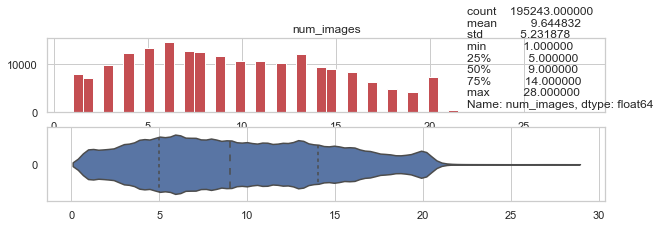

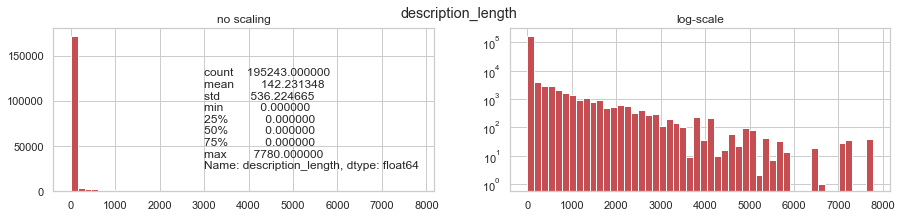

Cosine simliarity between description_length conditioned on resrevation_type
Use the least samples out of all separated class nsamp = 1355
The (average and median) cosine similarity between tag 0.0 and 1.0 = (0.06730932313013167 and 0.0)
The (average and median) cosine similarity between tag 0.0 and 2.0 = (0.06787391239226045 and 0.0)
The (average and median) cosine similarity between tag 1.0 and 2.0 = (0.02595656377227979 and 0.0)


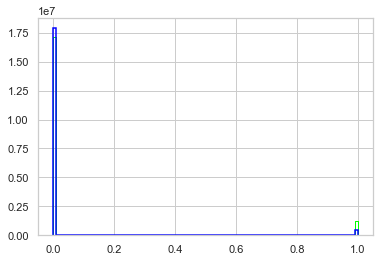

In [30]:
# pairplot showing numeric variables conditioned on target classes scatter plots
sns.set(style="whitegrid")
pp = sns.pairplot(df_plot,  vars=['actual_price','recommended_price','description_length','num_images'],
            hue='reservation_type', diag_kind='hist')
    # make sure the reservation_type is string instead of the original float or int
pp.set(xticklabels=[]);
plt.show()

plt.figure(figsize=(15,1))
print('percentage and number of NaNs in reservation_id = %s%% and %s'%(round(sum(np.isnan(df['reservation_id']))/df.shape[0]*100,2),sum(np.isnan(df['reservation_id']))))
print('Show the reservation_id with NaN (black) and values (white)')
masked_array = np.array(df['reservation_id'].values.reshape(1,-1))
masked_array[~np.isnan(df['reservation_id'].values.reshape(1,-1))]=1.
cmap = cm.Greys
cmap.set_bad(color=[0, 0, 0])
plt.pcolormesh(masked_array, cmap=cmap)
#plt.plot(masked_array,cmap=cmap)
plt.show()

print('Correlation matrix visualized between numeric variables')
corrp = Corrplot(df[['actual_price','recommended_price','description_length','num_images']])
corrp.plot(figsize=(12,6),upper='ellipse')
plt.show()




# is_delivery frequencies
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.bar(['0','1'],[sum(df['is_delivery']==0),sum(df['is_delivery']==1)])
plt.title('is_delivery')
plt.subplot(122)
plt.bar(['0','1'],[sum(df['is_recent_model']==0),sum(df['is_recent_model']==1)])
plt.title('is_recent_model')

# do a chi-square table and test here
print("Chi squared test of is_recent_model and is_delivery")
chisqr,p = chi_square_test.chi2_and_p(df['is_recent_model'],df['is_delivery'])

# do a chi-square test for all features
print("Chi squared test for all features")
chi2_all,p_all = chi2(df_x,y_cat)
print(chi2_all,p_all)

# price
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.title('actual price (red) vs recommended price (blue)')
plt.hist(df['actual_price'],100,color='r',histtype=u'step')
plt.hist(df['recommended_price'],100,color='b',histtype=u'step')
plt.text(300 ,5000, dfstats['actual_price'])
plt.text(600 ,5000, dfstats['recommended_price'])
plt.xlabel('price')
plt.subplot(212)
red_square=dict(markerfacecolor='r', marker='s')
plt.boxplot(df['actual_price'],vert=False, flierprops=red_square)
plt.show()

plt.figure(figsize=(10,5))
plt.suptitle('prices at reservation_type=0(red), 1(blue), 2(green)')
plt.subplot(121)
plt.hist(df['actual_price'][df['reservation_type']==0],bins=50,log=True,color='r',histtype=u'step')
plt.hist(df['actual_price'][df['reservation_type']==1],bins=50,log=True,color='b',histtype=u'step')
plt.hist(df['actual_price'][df['reservation_type']==2],bins=50,log=True,color='g',histtype=u'step')
plt.title('actual')
plt.subplot(122)
plt.hist(df['recommended_price'][df['reservation_type']==0],bins=50,log=True,color='r',histtype=u'step')
plt.hist(df['recommended_price'][df['reservation_type']==1],bins=50,log=True,color='b',histtype=u'step')
plt.hist(df['recommended_price'][df['reservation_type']==2],bins=50,log=True,color='g',histtype=u'step')
plt.title('recommended')

plt.show()

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df['recommended_price'],df['actual_price'])
plt.text(400,0,'slope = %s \nintercept = %s \nr^2 = %s \np_val = %s \nstd_err = %s'%\
         (slope, intercept, r_value**2, p_value, std_err))
plt.scatter(df['recommended_price'],df['actual_price'])
plt.xlabel('recommended price')
plt.ylabel('actual price')
plt.show()

# num_images (hist)
plt.figure(figsize=(10,3))
plt.subplot(211)
plt.title('num_images')
plt.hist(df['num_images'],50,color='r')
plt.text(22 ,1000, dfstats['num_images'])

# num_images (violin plot)
plt.subplot(212)
sns.violinplot(data=df['num_images'].values,inner="quartile",orient=u'h')
plt.show()

# description_length 
plt.figure(figsize=(15,3))
plt.suptitle('description_length')
plt.subplot(121)
plt.title('no scaling')
plt.hist(df['description_length'],bins=50,color='r')
plt.text(3000 ,25000, dfstats['description_length'])
plt.subplot(122)
plt.hist(df['description_length'],bins=50,color='r',log=True)
plt.title('log-scale')
plt.show()

print("Cosine simliarity between description_length conditioned on resrevation_type")
cs = average_cosine_similarity(df['description_length'].values,df['reservation_type'].values,df.shape[0],nbootstrap=10)


The three distributions for all three tags of the reservation_type are quite overlapped for both recommended and actual prices. Therefore it might be really hard to separate the classes for reservation_type according to the prices. But the recommended_price seems to be more separated than actual price, so we may just select recommended_price as the price feature.

description_length has 75% percentile data at zero, but the cosine similarity between each conditioned on the three reseravtion_type have very high "disimilarity" at cosine similarity=0. Which means that description_length separates the classes pretty well. We should include this into our prediction.

Colinearity of features:
The "is_delivery" and "is_recent_model" chi-square test shows they are significantly dependent. The "actual price" and "recommended price" are also significantly linearly dependent with a high $R^2$. 

## Target EDA

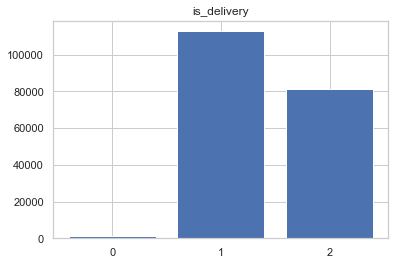

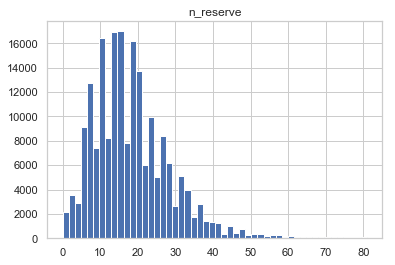

/usr/local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



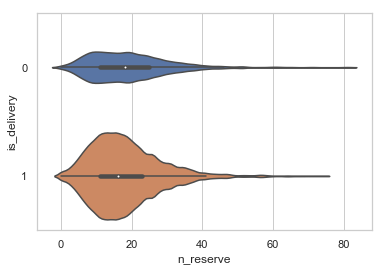

In [31]:
# revservation_type
plt.bar(['0','1','2'],[sum(df['reservation_type']==0),sum(df['reservation_type']==1),sum(df['reservation_type']==2)])
plt.title('is_delivery')
plt.show()

plt.hist(df['n_reserve'],50)
plt.title('n_reserve')
plt.show()

#sns.violinplot(x="n_reserve",y="is_delivery",data=df[['n_reserve','is_delivery']], scale="width", palette="Set3")
#sns.violinplot(data=df[['n_reserve','is_delivery']], scale="width", palette="Set3")
sns.violinplot(x=df['n_reserve'],y=df['is_delivery'].astype(str),scale ="count",orient=u'h')
plt.show()

For some reason the 0th category small samples are not plotted in the violin plot, and 1 and 2 becomes 1 and 0 respectively, weird...

Let's split the reservation number into two classes (reservation_type= {0,1}, {2}), and get a first look at how similar the classes are using cosine similarity function. Note that cosine similarity results are similar if we changed the class to using n_reservation with any threshold (e.g., threhold=15):

Use the least samples out of all separated class nsamp = 1000
The (average and median) cosine similarity between tag False and True = (0.4227765912144966 and 0.31622776601683794)


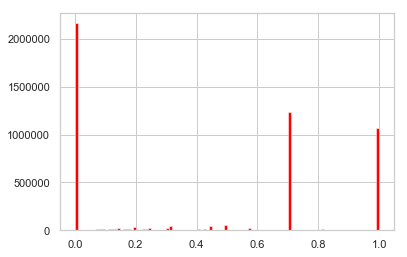

In [213]:
#average_cosine_similarity(x,y,nsamp,nbootstrap=10)
cs_total = average_cosine_similarity.plot_cs(x,y_cat==2,nsamp=1000,nbootstrap=5)
#cs_total = average_cosine_similarity(x,y_cat==2,1000,5)
#np.linalg.norm(a-b) maybe do pairwise distance?

The cosine similarity between target {2} and target {0,1} distribution are quite binary. With high similarity and low similarity quite sparated to the extremes.

Let's see if doing PCA transform can help separate the two sample classes:

In [32]:
pca = PCA(n_components=x.shape[1]) # use all 
pca.fit(x)

PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [33]:
s = pca.singular_values_
print(s)  # just the eigenvalues of the PC direction vectors, also the stdev of the PCs

[2.36941876e+05 3.17776567e+04 8.00781480e+03 2.23030351e+03
 2.05296110e+02 1.88772658e+02]


In [34]:
print(pca.explained_variance_ratio_) # ([i/sum(pca.singular_values_**2) for i in pca.singular_values_**2])

[9.81143164e-01 1.76478773e-02 1.12066750e-03 8.69313996e-05
 7.36563472e-07 6.22768905e-07]


The sigular values are just the PC stdev of the PC axes, and the explained variance are just the component variances (i.e., squared stdev) divide by the total variance. The top two axes captures >98% of the variance.

In [35]:
P = pca.transform(x) # the projection of all samples on all PC axes, 
PC_normal = np.asarray([P[:,i]/s[i] for i in range(len(s))]).T # normalized PC: PC divided by sigular values
# we can use P = PCA(n_components=2).transform(x)  if we just want the projections on the first 2 components, 
# this gives the same values as the full transformation, but just trancated 
#average_cosine_similarity(PC_normal[:,:2],y_cat>1,10000) # computes cosine simlilarity between all pairwise samples in x1 and x0
#average_cosine_similarity(PC_normal[:,:4],y_cat>1,10000) # computes cosine simlilarity between all pairwise samples in x1 and x0


Despite top 2 PC axes capturing most of the variance, the cosine similarity distribution is much more spreaded over -1 to 1 by using top 4 PC axes, without high similarity samples. The mean and median consine similarity are very low, which shows that the two classes in PCA feature space are probably more separated.

Let's see how the projection behaves on the 2 and 3 leading PC axes in a plot:

Samples: Class 0 (red) = 1355, Class 1 (blue) = 112740, Class 2 (green) = 81148


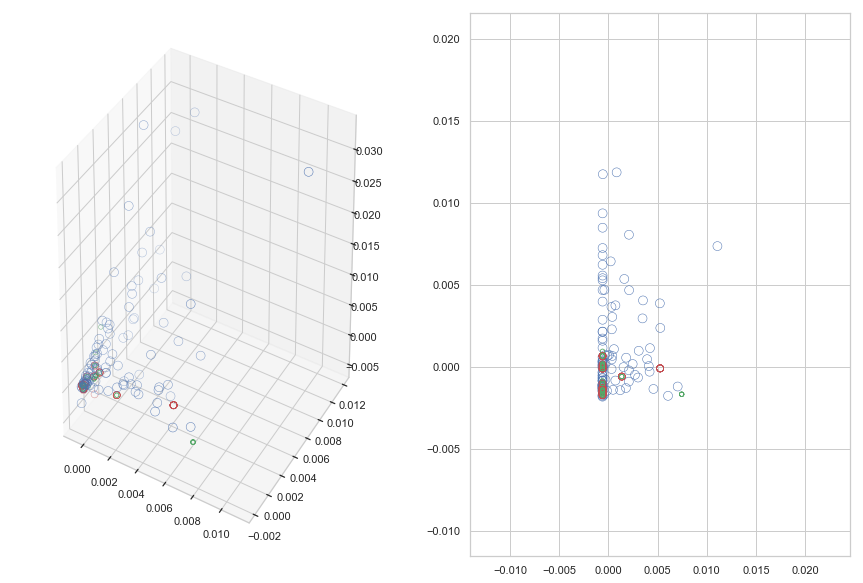

In [36]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(121, projection='3d')
print("Samples: Class 0 (red) = %s, Class 1 (blue) = %s, Class 2 (green) = %s"%(sum(y_cat==0),sum(y_cat==1),sum(y_cat==2)))
ax.scatter(PC_normal[y_cat==0,0][:100], PC_normal[y_cat==0,1][:100], PC_normal[y_cat==0,2][:100], edgecolors='b', s=80, facecolors='none', linewidths=0.5, label='Class 0')
ax.scatter(PC_normal[y_cat==1,0][:100], PC_normal[y_cat==1,1][:100], PC_normal[y_cat==1,2][:100], edgecolors='r', s=50, facecolors='none', linewidths=0.5, label='Class 1')
ax.scatter(PC_normal[y_cat==2,0][:100], PC_normal[y_cat==2,1][:100], PC_normal[y_cat==2,2][:100], edgecolors='g', s=20, facecolors='none', linewidths=0.5, label='Class 2')

ax2 = fig.add_subplot(122)
ax2.scatter(PC_normal[y_cat==0,0][:100], PC_normal[y_cat==0,1][:100], edgecolors='b', s=80, facecolors='none', linewidths=0.5, label='Class 0')
ax2.scatter(PC_normal[y_cat==1,0][:100], PC_normal[y_cat==1,1][:100], edgecolors='r', s=50, facecolors='none', linewidths=0.5, label='Class 1')
ax2.scatter(PC_normal[y_cat==2,0][:100], PC_normal[y_cat==2,1][:100], edgecolors='g', s=20, facecolors='none', linewidths=0.5, label='Class 2')
plt.show()

Seems like the three classes are better separated (except some outliers) in the PCA feature space. We want to see if the highly nonlinear DNN with multi-output architecture captures this nonlinear decision boundary!

Since rescaling is recommended for reasons such as making feature space more "spherical" instead of "elliptical" to speed up the stochastic gradient descent. Therefore we will just work on the normalized PC to avoid using `sklearn.preprocessing` to rescale the data.

We are going to look at multi-linear regression (for n_reservation label), softmax regression (for reservation_type label), SVM (for reservation_type label) and finally DNN (for both reservation_type and n_reservation labels).

Let's split the data into 80% training, 10% validation and 10% testing:

In [334]:
PC_normal,x,y_num,y_catx = shuffle(PC_normal,x,y_num,y_catx,random_state=0) # shuffle along the first axis to de-order the samples
#scaler = preprocessing.StandardScaler().fit(x) # standard normal z-scaling
#xz = scaler.transform(x) # z-scaling
#x_train,x_valid,x_test = x[:ntrain,:], x[ntrain:nvalid,:], x[nvalid:,:] # no scaling
#x_train,x_valid,x_test = xz[:ntrain,:], xz[ntrain:nvalid,:], xz[nvalid:,:] # z scaling
nPC = [5] # used number of PCA features for prediction
def split_train_valid_test(x,proportion=[0.8,0.9]):
    ntrain = round(proportion[0]*x.shape[0])
    nvalid = round(proportion[1]*x.shape[0])
    return x[:ntrain], x[ntrain:nvalid], x[nvalid:] 
# use only the highest variance PC axes, which is the top 2
#import stats
# standardize the continuous variable
#x[:,1:5] = (x[:,1:5]-x[:,1:5].mean())/x[:,1:5].std()
#x_s = (x - x.mean()) # standardized x
x_train,x_valid,x_test             = split_train_valid_test(x)
#x_train,x_valid,x_test             = split_train_valid_test(PC_normal[:,nPC])
y_num_train,y_num_valid,y_num_test = split_train_valid_test(y_num)
y_cat_train,y_cat_valid,y_cat_test = split_train_valid_test(y_cat)
y_cat_trainx,y_cat_validx,y_cat_testx = split_train_valid_test(y_catx)
print(x_train.shape, x_valid.shape, x_test.shape, y_num_train.shape, y_cat_train.shape)


(156194, 6) (19525, 6) (19524, 6) (156194,) (156194,)


# Feature selection and reduction (classification problem)
For a first look, I used Logistic regression with a reduction from 6 to 2 features, and a balanced class training. Notice this is very idealistic to balance the 0th category since it's nearly non-existent. But just for exploration purpose we included all the classes. The model is trained with L2 regularization which reduces the colinearity (i.e., making the coefficiences less sensitive) between features. Also used 3-fold cross validation for the model fitting.

In [ ]:
# modified sample codes from https://scikit-learn.org/stable/auto_examples/compose/plot_compare_reduction.html
# Authors: Robert McGibbon, Joel Nothman, Guillaume Lemaitre

# Create a temporary folder to store the transformers of the pipeline
cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)
pipe = Pipeline([
    # the reduce_dim stage is populated by the param_grid
    ('reduce_dim', None),
    ('classify', LogisticRegressionCV(cv=5, penalty='l2', 
      class_weight='balanced', solver='lbfgs',multi_class='multinomial')),
     #RandomForestClassifier(n_estimators=100, max_depth=x_train.shape[1]))
],memory=memory)#xgb.XGBClassifier())

N_FEATURES_OPTIONS = [2, 4, 6]
C_OPTIONS = [1, 10, 100, 1000] # the regularization parameter (inverse of lambda),
                    # the larger the more regularizated for SVC (classify_c) and logistic (classify_Cs)
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7), NMF()], #Non-negative matrix factorization (NMF)
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
#        'classify__C': C_OPTIONS
        'classify__Cs': C_OPTIONS
    },
    {
        'reduce_dim': [SelectKBest(chi2)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
#        'classify__C': C_OPTIONS
        'classify__Cs': C_OPTIONS
    },
]
reducer_labels = ['PCA', 'NMF', 'KBest(chi2)']

grid = GridSearchCV(pipe, cv=3, n_jobs=1, param_grid=param_grid)
#digits = load_digits()
grid.fit(x_train, y_cat_train)

# Delete the temporary cache before exiting
#rmtree(cachedir)



[0.44540123 0.48693932 0.48697133] [0.5 4.5 8.5] PCA
[0.45500467 0.48694572 0.50713216] [1.5 5.5 9.5] NMF
[0.42340295 0.47649718 0.48697133] [ 2.5  6.5 10.5] KBest(chi2)
Best parameters set found on development set:
{'reduce_dim__n_components': 6, 'classify__Cs': 1, 'reduce_dim': NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=6, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)}


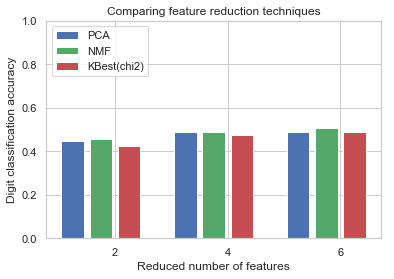

In [263]:

#mean_score = np.zeros([len(C_OPTIONS),len(N_FEATURES_OPTIONS)])
mean_score_reducer = [np.zeros([len(C_OPTIONS),len(N_FEATURES_OPTIONS)]) for _ in range(len(reducer_labels))] # create three element [PCA, NMF, KBest]
# define a dict for the parameter grid so we can resave the mean score and get the max from all C options for each N feature reduction
idict = [{2:0, 4:1, 6:2}, {1:0, 10:1, 100:2, 1000:3}, {'PCA':0,'NMF':1,'Sel':2}]
# {{N_FEATRUES_OPTIONS}, {C_OPTIONS}, {reducer_labels}}
for mean, std, params in zip(grid.cv_results_['mean_test_score'], 
                             grid.cv_results_['std_test_score'],
                             grid.cv_results_['params']):
#    print("%0.3f (+/-%0.03f) for %r"
#          % (mean, std * 2, params))
    #if kk<= (len(N_FEATURES_OPTIONS)*len(reducer_labels)-1):#*(len(C_))
    i = idict[1][params['classify__Cs']] # rows
    k = idict[2][str(params['reduce_dim'])[:3]]
    if k<2:
        j = idict[0][params['reduce_dim__n_components']]
    else:
        j = idict[0][params['reduce_dim__k']]
    mean_score_reducer[k][i,j] = mean    
#mean_score_max = [np.zeros([1,len(N_FEATURES_OPTIONS)]) for _ in range(len(reducer_labels))] 
mean_score_max = [np.array([]) for _ in range(len(reducer_labels))] 
for k in range(len(reducer_labels)):
    mean_score_max[k] = mean_score_reducer[k].max(axis=0) 
bar_offsets = (np.arange(len(N_FEATURES_OPTIONS))*(len(reducer_labels) + 1) + .5)
plt.figure()
COLORS = 'bgrcmyk'
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_score_max)):
    print(reducer_scores,bar_offsets+i,label)
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])
#print(grid.cv_results_['mean_test_score'])
plt.title("Comparing feature reduction techniques")
plt.xlabel('Reduced number of features')
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel('Digit classification accuracy')
plt.ylim((0, 1))
plt.legend(loc='upper left')

print("Best parameters set found on development set:")
print(grid.best_params_)    

plt.show()

This shows that we need more features for a better prediction using a logistic regression. But let's see the feature importance before making judgements on single features.

## Feature importance for classification problem
Let's start with general regression and then on trees. Important thing to know is that feature importance should actually be done after showing model performance. So that we're not misinterpreting whether a feature is actually important. But here we just want to get a taste of how IMPORTANT this method is and how each feature are treated differently in each model. So we'll show the model performance at the next section.

### Logistic Regression: Ridge (L2 penalty)  


In [ ]:
# Define a dict to store all model feature importance rankings
ranks = {}
# our features
colnames = df_x.columns        

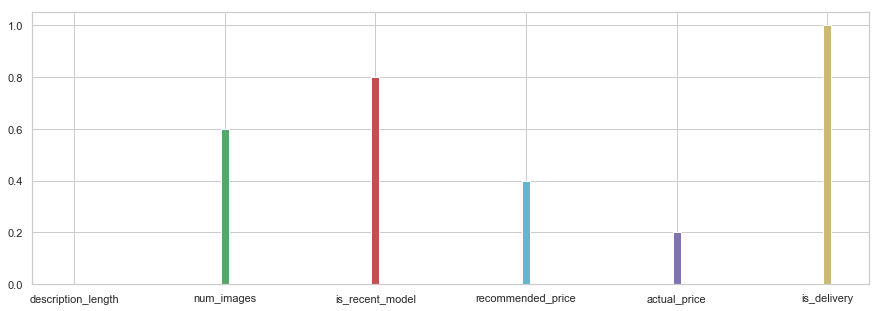

In [435]:
logreg_ridge = LogisticRegressionCV(cv=5, penalty='l2', class_weight='balanced', solver='lbfgs',multi_class='multinomial')
logreg_ridge.fit(x_train,y_cat_train) # multinomial uses cross entropy 
# do a Recursive Feature Elimination (RFE)
ranks["RFE"] = feature_importance.rfe_rank(x_train,y_cat_train,logreg_ridge,colnames)
plt.figure(figsize=[15,5])
feature_importance.plot_rfe(ranks['RFE'])

Shown here is that description length is really not that important, and actual_price is less effective than recommended_price. Overall is_delivery is the most important. Now let's just see how the ridge regression performs with the full features

[[0.00239596 0.00042181 0.0009354  0.         0.00103608 0.00593313]]


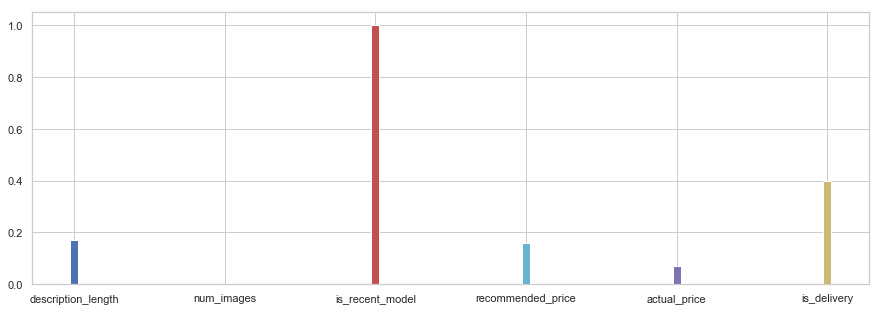

In [452]:
plt.figure(figsize=[15,5])
ranks["Ridge"] = feature_importance.ranking(*np.abs(logreg_ridge.coef_), colnames)
feature_importance.plot_rfe(ranks['Ridge'])

Seems like the logistic ridge regression coefficients show that is_recent_model is more sensitive than the other parameters. Let's see if trees shows some insights in feature importance:

### Decision tree

In [ ]:
clf_tree = DecisionTreeClassifier(max_depth=x_train.shape[1], min_samples_leaf=30, random_state=42)
clf_tree = clf_tree.fit(X=x_train, y=y_cat_trainx)

[[0.04998214 0.7555152  0.13783822 0.02677943 0.02426294 0.00562206]]


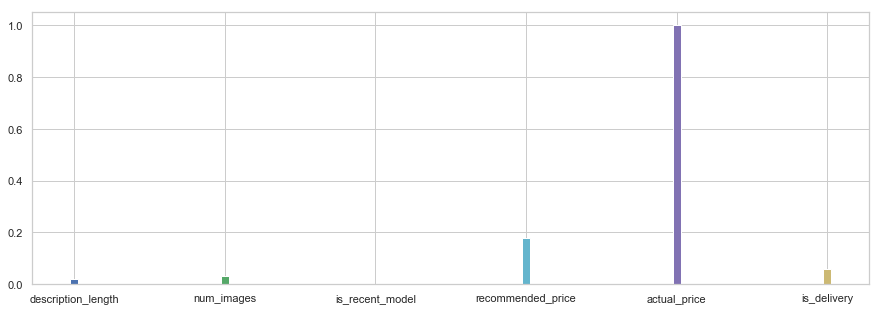

In [469]:
plt.figure(figsize=[15,5])
ranks["dtree"] = feature_importance.ranking(clf_tree.feature_importances_, colnames)
feature_importance.plot_rfe(ranks['dtree'])

### Random Forest

In [ ]:
clf_rtree = RandomForestClassifier(n_estimators=100, max_depth=x_train.shape[1],random_state=0)
#clf_rtree = clf_rtree.fit(X=x_train, y=y_cat_trainx)
# CV model
kfold = KFold(n_splits=10, random_state=7)
# kfold.split(x) returns the split indices
[clf_rtree.fit(x_train[itrain], y_cat_train[itrain]).score(x_train[itest], y_cat_train[itest]) for itrain, itest in kfold.split(x_train)]  

[[0.02300633 0.27198208 0.27884752 0.18949634 0.20878897 0.02787876]]


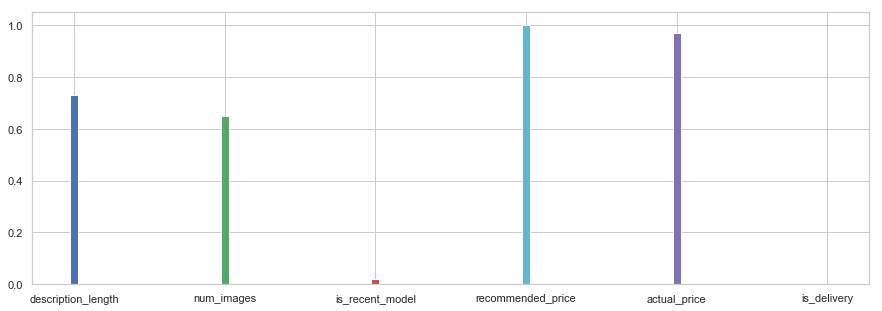

In [470]:
plt.figure(figsize=[15,5])
ranks["rtree"] = feature_importance.ranking(clf_rtree.feature_importances_, colnames)
feature_importance.plot_rfe(ranks['rtree'])

#### XGBoost

In [ ]:
#train_xgb = xgb.DMatrix(data = x_train, label=y_cat_trainx)
#test_xgb = xgb.DMatrix(data = x_test, label=y_cat_testx)
# alternatively:
# plst = param.items()
# plst += [('eval_metric', 'ams@0')]
#evallist = [(test_xgb, 'eval'), (train_xgb, 'train')]
#num_round = 100
#bst = xgb.train(param, train_xgb, num_round, evallist, early_stopping_rounds=10)
param = {'max_depth': x_train.shape[1], 'eta': 1, 'silent': 1, 'objective': 'multi:softprob'} 
# softmax gives the max class as output, softprob give probabilities in all classes
param['booster'] = 'gbtree'
param['nthread'] = 4 # Number of parallel threads used to run XGBoost
param['eval_metric'] = 'mlogloss' 
#param['eval_metric'] = ['auc', 'logloss'] # area under ROC curve
param['num_class'] = 3
xgb_model = xgb.XGBClassifier(param=param)
# CV model
kfold = KFold(n_splits=10, random_state=7)
# kfold.split(x) returns the split indices
[xgb_model.fit(x_train[itrain], y_cat_train[itrain]).score(x_train[itest], y_cat_train[itest]) for itrain, itest in kfold.split(x_train)]  
# xgb_kaccuracy = cross_val_score(xgb_model, x_train, y_cat_train, cv=kfold)
#print("Accuracy: %.2f%% (%.2f%%)" % (xgb_kaccuracy.mean()*100, xgb_kaccuracy.std()*100))

[[0.02186589 0.3148688  0.25801748 0.1632653  0.212828   0.02915452]]


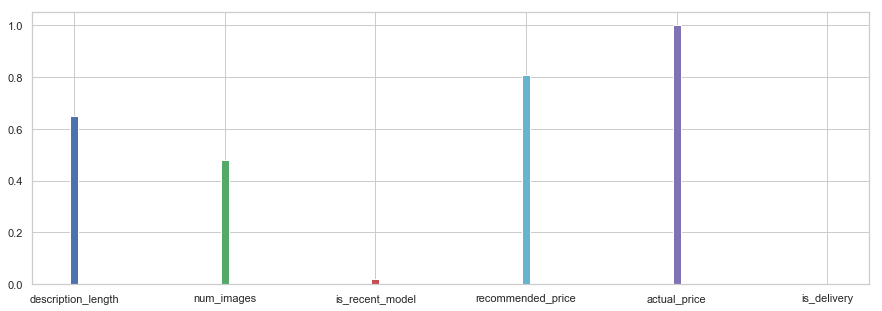

In [471]:
plt.figure(figsize=[15,5])
ranks["xgb"] = feature_importance.ranking(xgb_model.feature_importances_, colnames)
feature_importance.plot_rfe(ranks['xgb'])

Here we can see that ensemble trees are treating four feature consistently more important than logisitc regression model. But we'll see later that logistic regression is actually a better model in our prediction, and the trees are overfitting most of the instances.

## Prediction for classification problem

### Decision Tree

[0.5 3.5 6.5] [1355, 9114, 9055] 0.0
[1.5 4.5 7.5] [5, 16111, 3408] 1.0
19524
mean accuracy = 53.334357713583536 %


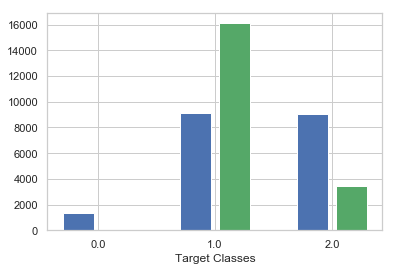

              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00      1355
     class 1       0.47      0.83      0.60      9114
     class 2       0.46      0.17      0.25      9055

   micro avg       0.47      0.47      0.47     19524
   macro avg       0.31      0.33      0.28     19524
weighted avg       0.43      0.47      0.40     19524



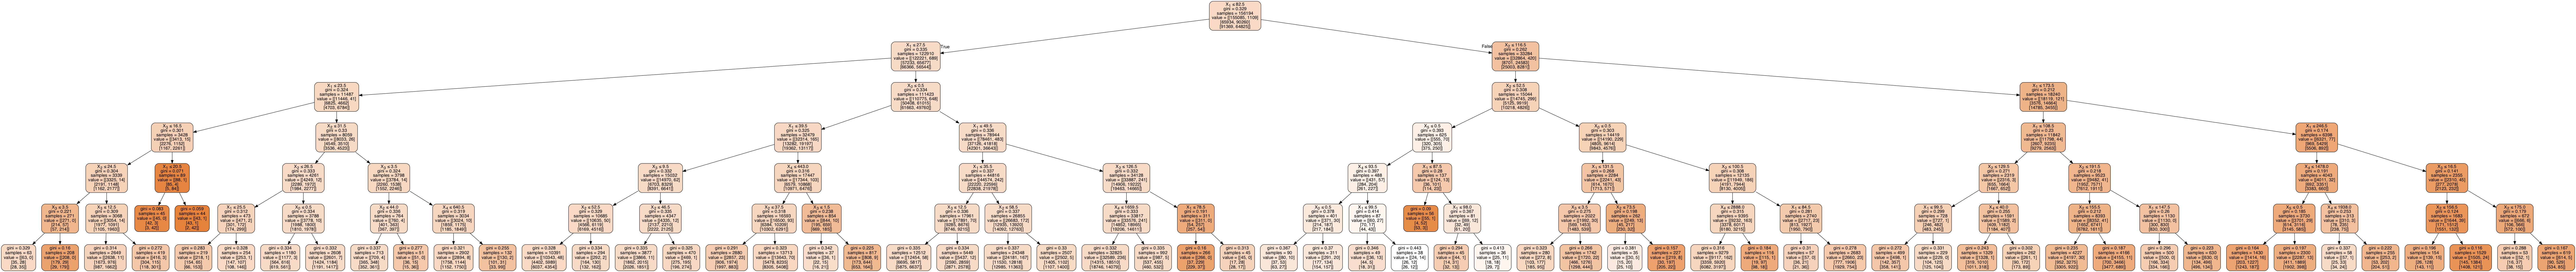

In [336]:
y_pred_tree = clf_tree.predict(x_test) # output [nsampes,nfeatures] binarized array
acc_plot(y_cat_test,lb.inverse_transform(y_pred_tree))
print(classification_report(y_cat_test,lb.inverse_transform(y_pred_tree),target_names=['class 0','class 1','class 2']))
plot_tree(clf_tree)

### Random Forest

[0.5 3.5 6.5] [1355, 9114, 9055] 0.0
[1.5 4.5 7.5] [0, 19523, 1] 1.0
19524
mean accuracy = 46.68612989141544 %


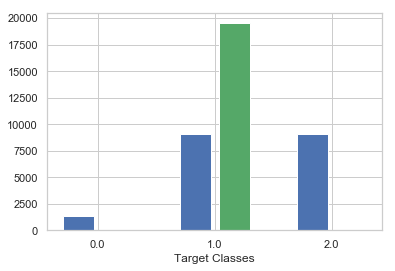

/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00      1355
     class 1       0.47      1.00      0.64      9114
     class 2       1.00      0.00      0.00      9055

   micro avg       0.47      0.47      0.47     19524
   macro avg       0.49      0.33      0.21     19524
weighted avg       0.68      0.47      0.30     19524



In [362]:
y_pred_rtree = clf_rtree.predict(x_test)
acc_plot(y_cat_test,y_pred_rtree)
print(classification_report(y_cat_test,y_pred_rtree,target_names=['class 0','class 1','class 2']))
#plot_tree(clf_rtree) # don't do this, error due to ensemble of trees 
# plot a single tree by indexing the 0th tree by tree.export_graphviz(forest_clf.estimators_[0], out_file='tree_from_forest.dot')

Accuracy is worse than using only one decision tree, the model is overfitting on class=1! This actually happened to XGBoost also as demonstrated below. As a preliminary conclusion, I think using a single decision tree is like an NN "early stopping" regularization, which reduces overfitting. Anyway, lets see the XGBoost result. 

### XGBoost

[0.5 3.5 6.5] [1355, 9114, 9055] 0.0
[1.5 4.5 7.5] [0, 19496, 28] 1.0
19524
mean accuracy = 46.73222700266314 %


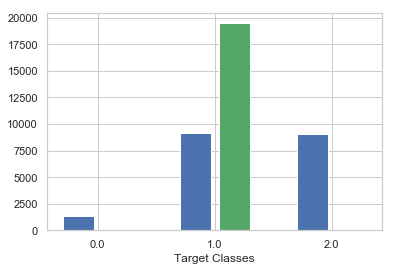

/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00      1355
     class 1       0.47      1.00      0.64      9114
     class 2       0.68      0.00      0.00      9055

   micro avg       0.47      0.47      0.47     19524
   macro avg       0.38      0.33      0.21     19524
weighted avg       0.53      0.47      0.30     19524



In [358]:
y_pred_xgb = xgb_model.predict(x_test)
acc_plot(y_cat_test,y_pred_xgb)
print(classification_report(y_cat_test,y_pred_xgb,target_names=['class 0','class 1','class 2']))

As previously concluded, XGBoost overfitted on the class=1. We can for sure tune the regularization parameters maximum depth, minimum child weight, gamma, etc. But for this project I want to leave the tweaking part aside.
### preliminary conclusion
The categorical target is best predicted by decision tree, which may be due to the regularizing affect of using a single tree, and the feature importance shows that "actual price" is the most crucial features! We'll just unsee the feature importance of the other tree models due to the lack of good predictions and overfitting to class=1.



## Feature importance for regression problem
Let's see if using the same feature to predict the numerical target shows more insight. Similar to previous study, we start by looking at the feature importance from regression models.
### Elastic Net (L1 and L2 regularization combined)

In [220]:
l1_ratio=0.5
alphas = np.array([1e-3, 1e-2, 1e-1, 1])
elastic = linear_model.ElasticNetCV(l1_ratio=l1_ratio,alphas=alphas,cv=10,fit_intercept=True).fit(x_train,y_num_train) 
print('a = %s and b = %s'%(alphas*l1_ratio,alphas*(1-l1_ratio)))
# a*L1 + b*L2
# alpha = a+b, l1_ratio = a / (a + b) => alpha * l1_ratio = a, alpha*(1-l1_ratio) = b
#1 / (2 * n_samples) * ||y - Xw||^2_2 + alpha * l1_ratio * ||w||_1 + 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2
y_pred_elastic = elastic.predict(x_test)
print('Mean squared error = %s'%str(mean_squared_error(y_num_test,y_pred_elastic)))

a = [0.0005 0.005  0.05   0.5   ] and b = [0.0005 0.005  0.05   0.5   ]
[-1.00485291 -3.78244865  3.17104548  0.          0.18092174 -0.27840569]
Mean squared error = 109.11616106725329


[[1.00485291 3.78244865 3.17104548 0.         0.18092174 0.27840569]]


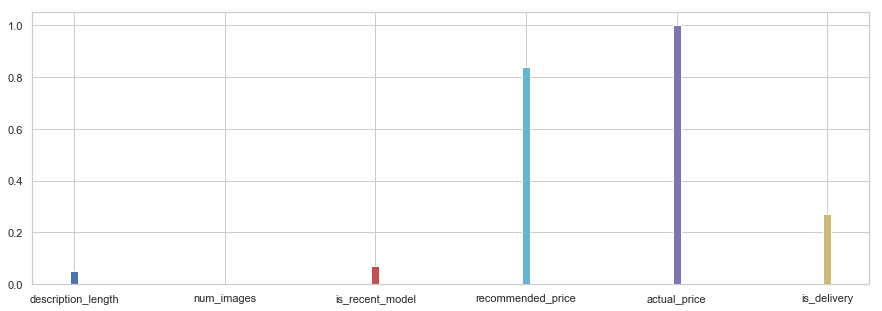

In [459]:
plt.figure(figsize=[15,5])
ranks["elastic"] = feature_importance.ranking(np.abs(elastic.coef_), colnames)
feature_importance.plot_rfe(ranks['elastic'])

### Ridge (L2 regularization) 


In [221]:
ridge = linear_model.RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1],
                                       fit_intercept=True,cv=10)
ridge.fit(x_train,y_num_train)
#print(ridge.coef_)
y_pred_ridge = ridge.predict(x_test)
print('Mean squared error = %s'%str(mean_squared_error(y_num_test,y_pred_ridge)))

Mean squared error = 154.62651096086867


In [464]:
plt.figure(figsize=[15,5])
ranks["linridge"] = feature_importance.ranking(np.abs(ridge.coef_), colnames)
feature_importance.plot_rfe(ranks['linridge'])


<bound method BaseEstimator.get_params of RidgeClassifierCV(alphas=array([0.001, 0.01 , 0.1  , 1.   ]),
         class_weight=None, cv=10, fit_intercept=True, normalize=False,
         scoring=None, store_cv_values=False)>


KeyError: 'linridge'

<Figure size 1080x360 with 0 Axes>

# Lasso Regression (L1 regularization with variable selection)

In [222]:
#lasso = linear_model.LassoClassifier(alpha=0.1,class_weight='balanced',fit_intercept=True).fit(x_train,y_num_train)
#print(lasso.coef_)
#y_pred_lasso = lasso.predict(x_test)
#print('Mean squared error = %s'%str(mean_squared_error(y_num_test,y_pred_lasso)))

### Ordinary Regression without regularization

In [486]:
reg = LinearRegression().fit(x_train[:,:],y_num_train)
reg.score(x_train[:,:],y_num_train)
y_pred_linreg = reg.predict(x_test[:,:])
sm_model = sm.OLS(y_num_train, sm.add_constant(x_train)).fit(disp=0)
vif = pd.DataFrame()
print(np.corrcoef(x_train[:,1:5].T))
vif["VIF Factor"] = [variance_inflation_factor(x_train[:,1:5], i) for i in range(x_train[:,1:5].shape[1])]
print(vif.round(1))
#print(sm_model.pvalues)
print(sm_model.summary())
print('Mean squared error = %s'%str(mean_squared_error(y_num_test,y_pred_linreg)))
#print(reg.coef_)
#print(reg.score(x_test,y_num_test)) #  R^2 is defined as (1 - u/v), where u is the residual sum of squares ((y_true - y_pred) ** 2).sum() and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum().

[[1.         0.88185979 0.19487576 0.03950824]
 [0.88185979 1.         0.24693488 0.05011878]
 [0.19487576 0.24693488 1.         0.08253905]
 [0.03950824 0.05011878 0.08253905 1.        ]]
   VIF Factor
0        10.9
1        12.7
2         2.6
3         1.1
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     701.6
Date:                Sat, 12 Jan 2019   Prob (F-statistic):               0.00
Time:                        15:48:11   Log-Likelihood:            -5.8500e+05
No. Observations:              156194   AIC:                         1.170e+06
Df Residuals:                  156187   BIC:                         1.170e+06
Df Model:                           6                                         
Covariance Type:            no

[[1.08705993e+00 5.76532529e-02 6.01564743e-02 7.40122777e-02
  5.21955881e-04 5.68293137e-01]]


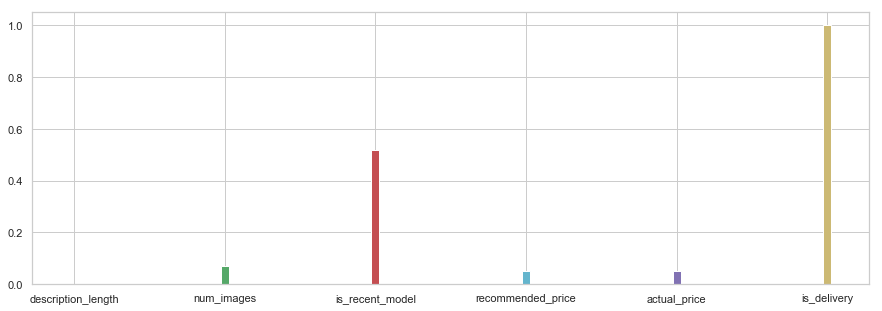

In [487]:
plt.figure(figsize=[15,5])
ranks["linreg"] = feature_importance.ranking(np.abs(reg.coef_), colnames)
feature_importance.plot_rfe(ranks['linreg'])

R^2=0.02 is the variance explained by the linear regression, so this is extremely low. Which means the sum squared error is really big, model not capturing much of the total variance. So essentially it's a failed prediction.

/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00      1355
     class 1       0.47      1.00      0.64      9114
     class 2       0.00      0.00      0.00      9055

   micro avg       0.47      0.47      0.47     19524
   macro avg       0.16      0.33      0.21     19524
weighted avg       0.22      0.47      0.30     19524

first two actual classes = [2. 1.]
first two predicted classes = [1. 1. 1. ... 1. 1. 1.]
first two predicted probalities [0 vs 1] = [[0.52562919 0.47437081]
 [0.53223372 0.46776628]
 [0.53413621 0.46586379]
 ...
 [0.53017862 0.46982138]
 [0.52268921 0.47731079]
 [0.5839849  0.4160151 ]]
score = 0.4668100799016595
[0.5 3.5 6.5] [1355, 9114, 9055] 0.0
[1.5 4.5 7.5] [0, 19524, 0] 1.0
19524
mean accuracy = 46.681007990165696 %


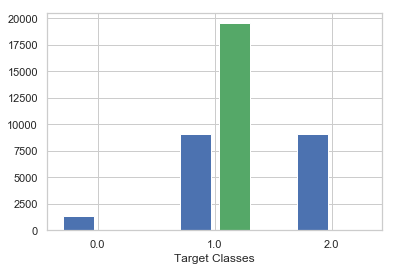

In [479]:
y_pred_lr_ridge = logreg_ridge.predict(x_test)
y_predp_lr_ridge = logreg_ridge.predict_proba(x_test)

#sm_model = sm.Logit(lb.inverse_transform(y_cat_train), sm.add_constant(x_train)).fit(disp=0)
#print(sm_model.pvalues)
#sm_model.summary()
print(classification_report(y_cat_test,y_pred_lr_ridge,target_names=['class 0','class 1','class 2'])) # support is just the # of samples detected or used
# X = [n_samples, n_features], y = [n_samples]
# C = Inverse of regularization strength; must be a positive float. 
#     Like in support vector machines, smaller values specify stronger regularization.
# solver = 'sag': stochastic average gradient descent
#        = 'lbfgs': some Newton method
print('first two actual classes = %s'%str(y_cat_test[:2]))
print('first two predicted classes = %s'%str(logreg_ridge.predict(x_test))) # predict class vs real class
print('first two predicted probalities [0 vs 1] = %s'%str(logreg_ridge.predict_proba(x_test))) # predict
print('score = %s'%str(logreg_ridge.score(x_test,y_cat_test))) # Score is the ratio of correctly predicted (TP+TN) samples.
acc_plot(y_cat_test,y_pred_lr_ridge)
plt.show()

Terrible score!!!! f1_score is pretty bad for class 0, maybe should put the class 0 into prediction since the vehicle is unavailable, but doesn't mean it wouldn't be rented...

The linear parameters/slope for regression shows the sensitivity to small changes, therefore:

The R^2 is at least much better than multilinear regression.

This coefficient matrix is n$_\text{classes}$ by n$_\text{features}$, the larger the slopes, the more impact on the features. Take row 3, which is the reservation_type=2, the first 2nd feature "actual_price" seem to have a negative impact, whereas 1st feature "is_delivery" has a positive impact.



### SVR


In [ ]:
from sklearn.svm import SVR
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
y_rbf = svr_rbf.fit(x_train[:10000,:], y_num_train[:10000]).predict(x_test)
print('mean squared error = %s'%str(mean_squared_error(y_rbf,y_num_test)))

### SVM
SVM with kernel computes the distance between every training points which is super expensive O($n_\text{features} \times n_\text{observations}^2$), so reduce the training samples to <100000, and don't do parameter grid search:


In [ ]:

clf = SVC(gamma='auto') # For non-linear classification use 
                        # gamma: Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. 
                        # Default is set to 'rbf' which is Radial Basis Function kernel
                        # multiclass uses one-vs-one, very slow...
clf.fit(x_train[:50000,:], lb.inverse_transform(y_cat_train[:50000,:]))
y_pred_svc = clf.predict(x_test)
print(x_test.shape,y_pred_svc.shape,sum(y_pred_svc))
print(classification_report(lb.inverse_transform(y_cat_test),y_pred_svc,target_names=['class 0','class 1','class 2']))
# let's do a grid search over the C and Gamma parameter space, 
# C (=1/\lambda) is a regularization scale , larger (smaller) C gives lower (higher) bias and higher (lower) variance
# Gamma (=1/\sigma) is a scale on kernel "width/variance", larger (smaller) Gamma gives lower (higher) bias and higher (lower) variance
# go to https://github.com/ginochen/ML_notes to learn more about these two parameters   
# The kernel trick is super expensive since it computes distance between each point!!
# see solution https://datascience.stackexchange.com/questions/989/svm-using-scikit-learn-runs-endlessly-and-never-completes-execution
#C_range = np.logspace(-2, 10, 3) # linear spaced between log10scale -2 to 10, and returns 10 based exponents of 10^-2, ...1
#gamma_range = np.logspace(-9, 3, 3) 
#param_grid = dict(gamma=gamma_range, C=C_range) 
#cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
#grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
#grid.fit(x_train, y_train)

#print("The best parameters are %s with a score of %0.2f"
#      % (grid.best_params_, grid.best_score_))

SVM is even worse at f1-score for class 2...

### Branched DNN - Multi-Output and Multi-Loss

In [ ]:
# Define model parameters
fpath = './'
batchsize = 100 # number of mini-batches per epoch
nsteps = 28 # number of samples in each mini-batch
ndim = x_train.shape[1]  # feature dimensions
hdim = 50 # hidden layer dimensions
hlayers= 100 # hidden layers
last_epoch = 0 # set to 0 for new model training
nepochs=100
dropoutRate = 0.5
learningRate=0.001
prediction_samp = 10000
ntrain = x_train.shape[0]
nvalid = x_valid.shape[0]

# initialize training and validation mini-batch data generator
train_gen = KerasBatchGenerator(x_train,y_num_train,y_cat_train, 
                          batchsize, ndim, nsteps, skip_steps=nsteps)
valid_gen = KerasBatchGenerator(x_valid,y_num_valid,y_cat_valid, 
                          batchsize, ndim, nsteps, skip_steps=nsteps)
#test_gen  = KerasBatchGenerator(np.concatenate((x_test,y_test.reshape(-1,1)),axis=1), 
#                          10, ndim, 1000, skip_steps=nsteps)
model, checkpointer  = branched_dnn(fpath).build_model(fpath,ndim,head_branch=0,nepochs=nepochs,hdim=hdim,hlayers=hlayers,
                                   dropoutrate=dropoutRate,learning_rate=learningRate)
history = model.fit_generator(train_gen.generate(), ntrain//(batchsize*nsteps), epochs=last_epoch+nepochs,
                validation_data = valid_gen.generate(), validation_steps=math.ceil(nvalid/(batchsize*nsteps)),
                callbacks=checkpointer,shuffle=True,initial_epoch=last_epoch,verbose=0)
branched_dnn.plot_hist(history)
#model = keras.models.load_model('./best_model.h5')
y_pred_dnn = model.predict_on_batch(x_test[:prediction_samp,:]) # predict on a single batch
y_cat_true_dnn = y_cat_test[:prediction_samp,:]
y_num_true_dnn = y_num_test[:prediction_samp]

In [ ]:
y_pred_dnn[0].shape

The accuracy of the two outputs saturated early at very low values!

In [ ]:
def cat_crossentropy(y_true,y_pred):
    entropy=0
    for i in range(y_true.shape[0]):
        entropy -= math.log(y_pred[i,y_true[i]==1]) # y_true: 0,1,2 are also the column index of y_pred
    return entropy/y_true.shape[0]
print('MSE = %s'%str(mean_squared_error(y_pred_dnn[0],y_num_true_dnn)))
cce = cat_crossentropy(y_cat_true_dnn,y_pred_dnn[1])
print('Categorical cross entropy = %s = average targeted probability of %s%%!'%(str(cce),str(round(math.exp(-cce)*100))))
print(classification_report(lb.inverse_transform(y_cat_true_dnn),lb.inverse_transform(y_pred_dnn[1]),target_names=['class 0','class 1','class 2']))


Notice the MSE for n_reservation prediction are pretty bad. The multi-output training did not result in anything better. In fact the MSE is close to multilinear regression and f1-score is close to SVM and much lower than softmax logistic regression. 

### Significance test 
This section analyzes the significance of the coefficients in the logistic regression model since it's the best overall performance one. The method uses log-likelihood ratio test by codes borrowed from [Ronald J. Nowling's github](https://gist.github.com/rnowling/ec9c9038e492d55ffae2ae257aa4acd9). The feature_null is the null hypothesis without the ith feature, assuming the effect is small, and the feature_alternative is the alternative hypothesis with all features. 

In [ ]:
"""
Copyright 2017 Ronald J. Nowling
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
    http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

import numpy as np
from scipy.stats import chi2
from sklearn.metrics import log_loss # the cross-entropy for categorical outcomes
# for Bernoulli binary outcomes this is just -log P(yt|yp) = -(yt log(yp) + (1 - yt) log(1 - yp))

def likelihood_ratio_test(features_alternate, labels, lr_model, features_null=None):
    """
    Compute the likelihood ratio test for a model trained on the set of features in
    `features_alternate` vs a null model.  If `features_null` is not defined, then
    the null model simply uses the intercept (class probabilities).  Note that
    `features_null` must be a subset of `features_alternative` -- it can not contain
    features that are not in `features_alternate`.
    Returns the p-value, which can be used to accept or reject the null hypothesis.
    """
    labels = np.array(labels)
    features_alternate = np.array(features_alternate)
    
    if features_null is not None:
        features_null = np.array(features_null)
        
        if features_null.shape[1] >= features_alternate.shape[1]:
            raise ValueError("Alternate features must have more features than null features")
        
        lr_model.fit(features_null, labels)
        null_prob = lr_model.predict_proba(features_null)[:, 1]
        df = features_alternate.shape[1] - features_null.shape[1]
    else:
        null_prob = sum(labels) / float(labels.shape[0]) * \
                    np.ones(labels.shape)
        df = features_alternate.shape[1]
    
    lr_model.fit(features_alternate, labels)
    alt_prob = lr_model.predict_proba(features_alternate)

    alt_log_likelihood = -log_loss(labels, # log likelihood is just the sum entropy over all instances
                                   alt_prob,
                                   normalize=False)
    null_log_likelihood = -log_loss(labels,
                                    null_prob,
                                    normalize=False)

    G = 2 * (alt_log_likelihood - null_log_likelihood) # this is the log likelihood ratio, since 2*log difference is the log of likelihood ratio squared
    p_value = chi2.sf(G, df)

    return p_value

pval = [None]*x.shape[1]
print(y.shape)
for i in range(x.shape[1]):
    ii = [j for j in range(x.shape[1]) if j!=i] # complement indices of i
    pval[i] = likelihood_ratio_test(x, y, logreg_ridge, features_null=x[:,ii])

Now that we finished the modeling part, we want to try out a microservice (take in parameters and predicting total number of reservations) to perform local hosted HTTP API calls for the DNN model. 

# Create model as a scalable web service
This is done with Flask decorator and gunicorn wrapped in Docker to listen to http API requests on Kubernetes. The reason to use API is to make our model accessible to other programs.

The DNN becomes a service app `classify.py`:

In [ ]:
# docker run -d -p 8080:8080 -v /Users/g/webpage/reservation_prediction/classify.py:/classify.py ml_example
from flask import Flask
from flask import request
from flask import jsonify
from flask import make_response

import tornado

import keras
from keras.models import load_model
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
import numpy as np

app = Flask(__name__) # creating flask object, used for unicorn

# add the flask API decorator to the turn the classify.py into an API service 
# which allows API requests from http GET (pull from server), POST (push to server) command
@app.route("/api/classify", methods=['GET', 'POST'])  # API calls like http://0.0.0.0:8080/api/classify?mpath=.&fpath=.&opath=.
def classify():
    # these parameters are added to the API
    mpath = str(request.args.get("mpath"))  # don't type "" in http, the inputs are default to strings
    fpath = str(request.args.get("fpath"))
    opath = str(request.args.get('opath'))
    x = pd.read_csv('%s/vehicles.csv'%fpath)
    x = x[x.columns[1:]] # drop the 'vehicle_id' column
    model = keras.models.load_model('%s/best_model.h5'%mpath)
    y_pred = model.predict_on_batch(x) # predict on a single batch
    lb = LabelBinarizer()
    lb.fit_transform([0,1,2])
    d = {'n_reservation':[i[0] for i in y_pred[0]], 'reservation_type':list(lb.inverse_transform(y_pred[1]))}
    df = pd.DataFrame(data=d)
    df.to_csv(opath)
    totalreserve = sum(y_pred[0])
    print('total reservation predicted = %s' %str(totalreserve))
    print('finished saving output to file: %s' % opath)
    # use `docker logs <container_id>` to see the printed outputs
    # and use interactive docker container to check the opath file
    # resp = make_response(df.to_json())  # <--- this returns a jasonify output
    return jsonify(total_reservation=str(totalreserve)) #resp

if __name__ == "__main__":
    #app.run(host='0.0.0.0', port=8080, debug=True) # this line is used for debugging only, use gnuicorn instead
    classify()

For debugging, I start the app by exporting the API and start listening on local host. For production, I'll wrap the API service in a Docker container. Let's start with debugging:

Export an ENV variable to linux env
> export FLASK_APP=classify.py

Run Flask (-m) on local host http://0.0.0.0 and start listening inputs on port 8080
> python -m flask run --host=0.0.0.0 -port=8080
 
From a client (e.g., my laptop), we can invoke the service by an http call
> curl --data "x1=5.1&x2=3.5&x3=44&x4=8.37" "http://0.0.0.0:8080/api/classify"

this will return the result in JSON object if that's how we coded our python to return a JSON object, e.g., { "total_reservation" : 257888 }

# Docker image for the API
Let's create a Docker image and container to wrap the API service using Dockerfile

In [ ]:
# This is a requirements.txt file with all python packages
gunicorn
flask-restful
scikit-learn
keras
sklearn
pandas
numpy
tensorflow

In [ ]:
# This is a Dockerfile which wraps classify.py API into the containerized environment
# base image is ubuntu
FROM ubuntu
RUN apt-get update && apt-get install -y \
python-pip \
python-dev \
python-numpy \
python-scipy \
python-pip

ADD . ./app/
WORKDIR ./app/

RUN pip install --upgrade -r requirements.txt

# Copy model code from current directory to docker image directory
# Caution, if compiled with a bad model, then don't rebuild the entire Dockerfile image
# simply mount the correct classify.py file to the container directory where you saved the copy
COPY ./classify.py ./app/
COPY ./vehicles.csv ./app/
COPY ./best_model.h5 ./app/
# when debugging classify.py just mount the host classify.py file to the classify.py file in the docker container, i.e., overwrite it
# docker run -v /Users/g/webpage/reservation_prediction/classify.py:/classify.py ml_example

# expose the port for the API
EXPOSE 8080


# run the API
# asyncronous services (parallel requesting service)
CMD ["gunicorn", "-w", "5", "-k", "gevent", "classify:app", "-b", "0.0.0.0:8080", "--timeout=5000"]
# syncronous services (sequential requesting service)
#CMD ["gunicorn", "classify:app", "-b", "0.0.0.0:8080"] # use the flask variable `app` in module `classfy` 
# for testing single thread
#CMD [ "python", "-m", "flask", "run", "--host=0.0.0.0", "-port=8080", "classify.py"]
# only the first input of CMD is the program, the rest are inputs to the program
# therefore if shell operations are use then must do 
# CMD ["sh", "-c", "gunicorn -w $(( 2 * cat /proc/cpuinfo | grep 'core id' | wc -l + 1 )) -k gevent classify:app -b 0.0.0.0:8080 --timeout=5000"]]

In [ ]:
# docker-compose.yml file to summarize the images in a JSON format
  version: "2"

  services:
    web:
      build: .
      ports:
        - "8080:8080"

    frontend:
      image: gcr.io/google-samples/gb-frontend:v4
      ports:
        - "80:80"
      environment:
        - GET_HOSTS_FROM=dns
      labels:
        kompose.service.type: LoadBalancer

There are two ways to build the dockerfile and run it by using 1) `docker` and 2) `docker-composer`. `docker composer` builds multiple images easily, it's like a summary file of all the services you want to deploy on the server. 

Let's build the Dockerfile and run it in background by `docker-compose`
> `docker-compose up -d --build`

This creates two service images, `web` and `frontend`. Note: might need to do `--force-recreate` when debugging the Dockerfile. See the ease of up and running the container?! Now lets see how `docker` command break down the steps.


Build a docker image called `ml_example` from the Dockerfile local directory
> `docker build -t ml_example .`

I copied/overwritten some files later from my local path into the container app path using
> `docker cp some_file <container_id>:./app/`

Notice the cp is only done on a single instance, if you opened a different container on the same image, you'll need to cp the file again.

Run the API in the container with my local directory mounted as `localapp` in the container
> `docker run -d -p 8080:8080 -v ./:/app/localapp ml_example`

There is one situation when I want to open multiple container using different mounting volumes, then I need to expose different ports from the container, e.g., port 5000. But since the prebuilt Dockerfile only exposes 8080 as the only listening port, all I need to do is
> `docker run -d -p 5000:8080 -v ./:/app/localapp ml_example`

Just make sure the Flask debugging line `app.run(host='0.0.0.0', port=8080, debug=True)` in classify.py is commented out, since this will expose the 8080 container port instead of 5000.

If for some reason the API is not running properly or things needed to be changed in the container interactively (or just do docker `commit` after `docker cp file_to_change <container_id>:./path/to/overwrite/changed/file/`) , just do
> `docker exec -it <container_id> /bin/bash`


change the necessary stuff and run gnicorn for testing manually
> `gunicorn classify:app -b 0.0.0.0:8080`

To run multiple asynchronous services, we can first see how many CPU cores are allowed
> `cat /proc/cpuinfo | grep 'core id' | wc -l`

Gunicorn suggest assigning 2*n+1 workers, where n is the number of CPU cores, therefore
> ``gunicorn -w $(( 2 * `cat /proc/cpuinfo | grep 'core id' | wc -l` + 1 )) -k gevent classify:app -b 0.0.0.0:8080 --timeout=5000``

`timeout=5000` is here to prevent worker timeout issue.

We can also use `gthread` (CPU-bound task) instead of `gevent` (IO-bound task) to handle the workers
> ``gunicorn -w $(( 2 * `cat /proc/cpuinfo | grep 'core id' | wc -l` + 1 )) -k gthread --thread=2 classify:app -b 0.0.0.0:8080 --timeout=5000``

This `gunicorn` line of command is included in the final version of the Dockerfile.

The API is started in the container and consistently listening on our local host port 8080 since we connected the container port directly to the local host port. A different container port doesn't affect the HTTP API calls.

(Notice here I mounted several local files into the container since this is done after the image was built. One can also use the COPY command in Dockerfile to add these file prebuilding.)

Once the container is running, let's do the HTTP API calls using the three input paths we specified in the API
> curl -i http://0.0.0.0:8080/api/classify?mpath=.&fpath=.&opath=./output.csv

As previously mentioned, this will return a output specified by the API `classify.py`. Note that we can also run http in browsers, but `curl` can easily generate all kinds of HTTP requests.

Now that we learned how to use Docker, Flask decorator and gunicorn to perform http API calls, it's time to move on to Kubernetes to perform scalable modeling!

Now we can run multiple request asynchronously on a single VM server. To scale this up, we like to go to cluster systems, e.g., Kubernetes.

Before doing so, let's push the created image to the docker hub/registry. Go to docker repository (https://cloud.docker.com/repository/list) to create a new repo called `test`.

Login the repo from commandline
> `docker login --username=gchen0119`

If the `classify.py` file is changed we can copy/overwrite the file in the container
> `docker cp ./classfiy <container_id>:./app/`

Then commit the change to the image at the REPOSITORY (e.g., gchen0119/test), 
> `docker commit <container_id> gchen0119/test:v2`

get the docker image we want to push to
> `docker images`

This will show up 
> `REPOSITORY                  TAG                 IMAGE ID            CREATED        `
> `gchen0119/test              v2                  d63349dea372        41 minutes ago `

set repo with tagged name (e.g., v2 for version 2) 
> `docker tag <image_id> gchen0119/test:v2`

push the image to my repo
> `docker push gchen0119/test`

This will be save to the registry on docker hub
> `docker.io/gchen0119/test`


# Kubernetes for scalability

### Brief intro of Kubernetes Pods
Let's first talk about what are the unit resources, `Pods`, on the Kubernetes cluster. A `Pod` is a group of containers, where resources can be specified on the container level in the `deployment.yaml` file, e.g., [CPU and memory usage](https://kubernetes.io/docs/concepts/configuration/manage-compute-resources-container/). The sum of resource usage of the containers forms the usage on the Pod level. A Kubernetes "service" have a load balancer that distributes a work load across a group of pods to perform the same task. 

On a higher level, the Kubernetes scheduler selects a cluster node for the Pod to run on. Each node has a limited resource provided for Pods. The scheduler will make sure that the total usage of the sum of container resources are less than the node resource to deploy a Pod. A Pod will fail to deploy if the capacity check by the scheduler fails. Anyway

### Let's start!
Let's use the command line tool `kubectl` and start a `minikube` as a single cluster test on a personal computer.
> `minikube start`


Issue the docker image
> `kubectl run ml-test --image=docker.io/gchen0119/test:v2 --port=8080`

> `kubectl expose deployment ml-test`

Show all pods available
> `kubectl get pods`

Show where're we running this cluster
> `kubectl cluster-info`

> `kubectl apply -f deployment.yaml`

Doing `kubectl get pods` will returns something like this
> `NAME                               READY     STATUS              RESTARTS   AGE` <br/>
> `ml-test-5f945f99b4-sv47l           0/1       ContainerCreating   0          59s` <br/>
> `test-deployment-769c66df8b-fkrmh   0/1       ContainerCreating   0          7s` <br/>
> `test-deployment-769c66df8b-mkl5z   0/1       ContainerCreating   0          7s` <br/>
> `test-deployment-769c66df8b-r8fbs   0/1       ContainerCreating   0          7s` <br/>

Where we have created 3 `replicas` of pods specified in `deployment.yaml`, and the STATUS is still trying to create the container VM instances. 


This will show how the image we deployed looks like on kubernetes such as how many pods deployed, and the status of pods
> `kubectl describe deployment ml-test`

If we originally had 2 pods deployed, and modified the yaml file to deploy a total of 4 pods, then 2 more new pods will be deployed
> `kubectl get pods`

If the image is READY (e.g., 1/1 for 1 pod ready, 0/1 for 0 pod read), then check the CLUSTER-IP of the containerized image by 
> `kubectl get services`

Copy the IP address (e.g., 10.97.167.197, and the `containerPort=8080` in the `deployment.yaml` file) to test out the deployed service
> `curl -i http://10.97.167.197:8080/api/classify?mpath=.&fpath=.&opath=./out.csv`

Notice this will fail with timeout error. The reason is the port we set in the docker container is listening on local host `0.0.0.0:8080`, instead of the IP address. Therefore we need to forward the port from the POD (e.g.,ml-test-5f945f99b4-sv47l) to the local host using 
> `kubectl port-forward ml-test-5f945f99b4-sv47l 8080:8080`

Now this will work
> `curl -i http://0.0.0.0:8080/api/classify?mpath=.&fpath=.&opath=./out.csv`

Check the log file of the containerized service
> `kubectl logs ml-test-5f945f99b4-sv47l`

> `[2019-01-14 21:52:36 +0000] [1] [INFO] Starting gunicorn 19.9.0` <br/> 
> `[2019-01-14 21:52:36 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)` <br/>
> `[2019-01-14 21:52:36 +0000] [1] [INFO] Using worker: gevent` <br/>
> `[2019-01-14 21:52:36 +0000] [8] [INFO] Booting worker with pid: 8` <br/>
> `[2019-01-14 21:52:36 +0000] [9] [INFO] Booting worker with pid: 9` <br/>
> `[2019-01-14 21:52:36 +0000] [10] [INFO] Booting worker with pid: 10` <br/>
> `[2019-01-14 21:52:36 +0000] [11] [INFO] Booting worker with pid: 11` <br/>
> `Using TensorFlow backend.` <br/>
> `Using TensorFlow backend.` <br/>
> `Using TensorFlow backend.` <br/>
> `Using TensorFlow backend.` <br/>

Add additional pods to deployment when the average pods CPU usage exceeds 80%, also specify a minimum and maximum of pods deployed
> `kubectl autoscale deployment ml-test --cpu-percent=80 --min=2 --max=5`

Check the horizontally scaled autoscaler by
> `kubectl get hpa`

> `NAME      REFERENCE            TARGETS         MINPODS   MAXPODS   REPLICAS   AGE` <br/>
> `ml-test   Deployment/ml-test   <unknown>/80%   2         5         2          8m` <br/>

There! The minimum pod number is set to 2 for the deployment `ml-test`. The advantage of using dynamic scaling is that we can minimize the overhead cost of CPUs by only requesting when certain criterias are met, e.g., CPU in pods exceeds 80%.

### Monitoring performance
* Docker usage stats we care about: CPU, memory, network IO, block IO (persistent storage), and process and threads. 

* Kuberetes usage stats we care about: Pods running the containers (`kubectl describe pods`), core metrics (`kubectl top`), [Node Problem Detector](https://github.com/kubernetes/node-problem-detector).


# Deploying on Kubernetes

# Summary
The branching position, either at input layer or output layer, did not improve the multi-output results. Nevertheless, I still created a Dockerized scalable HTTP API for the model. The best model is surprisingly the simplest decision tree with feature importance weighted heavily on the "recommended price" feature. The Feature reduction method comparing PCA, NWF and KBest on the classification model all suggested to include all the features for a better prediction. 

# Reference
* [Endless run of kernel SVM](https://datascience.stackexchange.com/questions/989/svm-using-scikit-learn-runs-endlessly-and-never-completes-execution)
* [mathematical formulation of SVC](https://scikit-learn.org/stable/modules/svm.html)
* [argparse](https://www.pyimagesearch.com/2018/03/12/python-argparse-command-line-arguments/)
* [multi-output DNN](https://www.pyimagesearch.com/2018/06/04/keras-multiple-outputs-and-multiple-losses/)
* [why L1 norm encourages sparse solution](https://medium.com/mlreview/l1-norm-regularization-and-sparsity-explained-for-dummies-5b0e4be3938a)
* [XGBoost for python](https://xgboost.readthedocs.io/en/latest/python/python_intro.html)
* [Feature reduction/selection with Pipeline and GridSearchCV](https://scikit-learn.org/stable/auto_examples/compose/plot_compare_reduction.html#sphx-glr-auto-examples-compose-plot-compare-reduction-py)
* [Query data on Bigquery](https://www.kaggle.com/dansbecker/getting-started-with-sql-and-bigquery)
* [violin plots](https://seaborn.pydata.org/generated/seaborn.violinplot.html)
* [IO-bound or CPU-bound task using gevent or gthread](https://medium.com/@genchilu/brief-introduction-about-the-types-of-worker-in-gunicorn-and-respective-suitable-scenario-67b0c0e7bd62)
* [Feature ranking plots](https://www.kaggle.com/arthurtok/feature-ranking-rfe-random-forest-linear-models)
* [sqlalchemy](https://www.sqlalchemy.org/)
* [frontend vs backend tools](https://github.com/kamranahmedse/developer-roadmap/blob/master/readme.md)
* [encoding categorical features for ML](https://towardsdatascience.com/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159)

# Helper functions

In [50]:
# as before load all lib here

# k-fold cross validation, 
from sklearn.model_selection import KFold # k set to 3, 5, or 10 is the golden standard for cross validation
from sklearn.model_selection import StratifiedKFold # Use stratified cross validation to enforce class distributions when there are a large number of classes or an imbalance in instances for each class.
from sklearn.model_selection import cross_val_score

# parallel computing 
import psutil
#from multiprocessing import Pool # (can't use this under jupyter notebook) multiprocessing module has a major limitation due to "Pickling": it only accepts certain functions, and in certain situations. For instance any class methods, lambdas, or functions defined in __main__ wont’ work.
from multiprocess import Pool # use this instead


import scipy
import seaborn as sns
import pandas as pd
import numpy as np
import math
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_recall_fscore_support, mean_squared_error
from sklearn.metrics import roc_auc_score,roc_curve,auc,confusion_matrix, f1_score, fbeta_score
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import preprocessing #MinMaxScaler
from sklearn.utils import shuffle
import operator

# Pipeline with memoizer
from tempfile import mkdtemp
from shutil import rmtree
from joblib import Memory

# Feature EDA
# Plotly - Sankey Diagrams
import json, urllib
import plotly
import plotly.plotly as py
import pandas as pd
import numpy as np

# ggplot
#from ggplot import *

# correlation matrix elliptics plot between numeric variable
import pyensae 
from pyensae.graphhelper import Corrplot

# feature selection
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import RFE # recursive feature selection,
# RFE(estimator, n_features_to_select=None, step=1, verbose=0)[source]


from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegressionCV # logistic regression function p(x) = 1/(1+e^{b^T*x}), logit(p) = b^T*x
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# decision tree and plotting tools
from sklearn import tree
from sklearn.externals.six import StringIO  
from IPython.display import Image, display
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# balance imbalanced class
from imblearn.over_sampling import SMOTE

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout, Activation, LeakyReLU, BatchNormalization



import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


In [ ]:
# run function using pool.map in parallel mode
pool.close() # close any worker previously defined
psutil.cpu_count(logical=False) # after counting the cpu, we can specify the number of workers
# logical=True counts threads, but we are interested in cores
pool = Pool(psutil.cpu_count(logical=False)) # pool object gives us a set of parallel workers we can use to parallelize our calculations
# execute a computation(s) in parallel
result = pool.map(your_function, something_to_iterate_over)
result2 = pool.map(another_function, more_stuff_to_iterate_over)
# turn off your parallel workers at the end of your script
pool.close()

In [447]:
# Create our function which stores the feature rankings to the ranks dictionary
class feature_importance(object):
    def __init__(self,x,y):
        self.x = x
        self.y = y
    @staticmethod
    def ranking(ranks, names, order=1):
        minmax = preprocessing.MinMaxScaler()
        ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
        ranks = map(lambda x: round(x,2), ranks)
        return dict(zip(names, ranks))        
    @classmethod
    def rfe_rank(cls,x,y,fitted_model,colnames):
        rfe = RFE(fitted_model, n_features_to_select=1, verbose =3 ) # select until 1 feature left
        rfe.fit(x,y)
        return cls.ranking(list(map(float, rfe.ranking_)), colnames, order=-1)
    @staticmethod
    def plot_rfe(ranks):
        COLORS = 'bgrcmyk'
        for i,(key,val) in enumerate(ranks.items()):
            plt.bar(i*15, val, label=key, color=COLORS[i],log=False)
        plt.xticks(np.arange(len(ranks))*15, ranks.keys())
        plt.show()

In [355]:
def acc_plot(y_test,y_pred):
    '''
        Use this to plot binary outcomes accuracy and histogram plot
    '''
    uniqy = np.unique(y_test)
    bar_offsets = (np.arange(len(uniqy))*(2 + 1) + .5)
    COLORS = 'bgrcmyk'
    score = [[] for i in range(2)]
    for v in uniqy:
        score[0].append(sum(y_test==v))
        score[1].append(sum(y_pred==v))
    for i, (label, scores) in enumerate(zip(uniqy, score)):
        print(bar_offsets+i,scores,label)
        plt.bar(bar_offsets + i, scores, label=label, color=COLORS[i],log=False)
    plt.xlabel('Target Classes')
    plt.xticks(bar_offsets + label / 2, uniqy)
    print(y_pred.shape[0])
    meanacc=0
    for i in range(y_pred.shape[0]):
        meanacc += np.equal(y_pred[i],y_test[i])/y_test.shape[0] # compare equal rows
    print('mean accuracy = %s %%'%str((meanacc)*100))
#    plt.hist(lb.inverse_transform(y_test),density=True,log=True,bins=50,color=[0,0,1],rwidth=10)
#    plt.hist(lb.inverse_transform(y_pred),density=True,log=True,bins=50,color=[1,0,0],rwidth=0.5)
    plt.show()

In [280]:
# plot decision tree (plot random forest only if one single tree member selected)
def plot_tree(dtree):
    dot_data = StringIO()
    export_graphviz(dtree, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    display(Image(graph.create_png()))
    plt.show()

In [6]:
class KerasBatchGenerator(object):
    def __init__(self,x,y_num,y_cat,batchsize,ndim,nsteps,skip_steps):
        self.x=x
        self.y_num=y_num
        self.y_cat=y_cat
        self.batchsize=batchsize
        self.istart=0
        self.nsteps=nsteps
        self.skip_steps = skip_steps
        self.ndim = ndim
    def generate(self):
        x = np.zeros((self.nsteps, self.ndim))            
        y_num = np.zeros((self.nsteps, 1))
        y_cat = np.zeros((self.nsteps, 3))
        while True:
            for i in range(self.batchsize):
                x, y_num, y_cat = self.x[self.istart:self.istart+self.nsteps,:], \
                    self.y_num[self.istart:self.istart+self.nsteps], \
                    self.y_cat[self.istart:self.istart+self.nsteps,:]
                self.istart += self.skip_steps             
                yield x, {'num_output': y_num, 'cat_output': y_cat} # yield returns a set of x,y values for model.fit_generator to perform batch training
    @staticmethod
    def split_train_valid_test(x,proportion=[0.8,0.9]):
        ntrain = round(proportion[0]*x.shape[0])
        nvalid = round(proportion[1]*x.shape[0])
        return x[:ntrain], x[ntrain:nvalid], x[nvalid:]   

In [7]:
# The two output classes and two loss functions DNN model
class branched_dnn(object):
    def __init__(self,fpath):                      
        self.file = fpath+'/best_model.h5'                          
    @staticmethod
    def build_model(fpath,ndim,head_branch=1,nepochs=50,hdim=100,hlayers=20,dropoutrate=0.2,learning_rate=0.001):
        inputShape = (ndim,) # does not include the mini-batch/batchsize samples axis
        inputs = Input(shape=inputShape)
        if head_branch:
            numericBranch  = branched_dnn(fpath).build_branch_model(inputs, head_branch=head_branch, \
                         finalAct='relu',name='num_output',nout=1,nin=ndim,hdim=hdim, \
                         hlayers=hlayers,dropoutRate=dropoutRate)
            categoryBranch = branched_dnn(fpath).build_branch_model(inputs, head_branch=1,\
                         finalAct='softmax',name='cat_output',nout=3,nin=ndim,hdim=hdim, \
                         hlayers=hlayers,dropoutRate=dropoutRate)
        else:
            numericBranch, categoryBranch = branched_dnn(fpath).build_branch_model(inputs, head_branch=head_branch,\
                         nout1=1,nout2=3,finalAct1='relu',finalAct2='softmax',name1='num_output', \
                         name2='cat_output',nin=ndim,hdim=hdim, hlayers=hlayers,dropoutRate=dropoutRate)
        model = Model(inputs=inputs, outputs=[numericBranch, categoryBranch],name="branchednet")
        
        losses = {"num_output": "mean_squared_error", "cat_output": "categorical_crossentropy"}
        lossWeights = {"num_output": 1.0, "cat_output": 1.0}
        opt = Adam(lr=learning_rate, decay=learning_rate/nepochs) # with learning rate decay
        model.compile(optimizer=opt, loss=losses, loss_weights = lossWeights, metrics=["accuracy"])
        # checkpointer = keras.callbacks.ModelCheckpoint(filepath=datapath + '/model-{epoch:02d}.hdf5', verbose=1)
        checkpointer = [EarlyStopping(monitor='val_loss', patience=20), # patience: wait for at least 5 epochs before early stopping
        ModelCheckpoint(filepath=branched_dnn(fpath).file, monitor='val_loss', save_best_only=True, verbose=0)]
        # model.summary()
        return model, checkpointer
    def build_branch_model(self,x,head_branch,**param):
        '''
        head_branch=1 set's the branch at the input layer, otherwise 
        head_branch=0 set's the branch at output layer
        param: put all the DNN parameters here
        finalAct: 'softmax','sigmoid' for categorical, 'linear' or 'relu' for numerical
        name: just name the branches as you wish, e.g., 'category_output', 'numeric_output'
        '''
        #model = Sequential()
        x = Dense(param['hdim'], input_dim=param['nin'], kernel_initializer='glorot_normal')(x)
        BatchNormalization()
        x = Activation('relu')(x)
        for _ in range(param['hlayers']-1):
            x = Dropout(param['dropoutRate'])(x)
            #model.add(Dense(hdim, kernel_initializer='glorot_normal', activation='relu')) 
            x = Dense(param['hdim'], kernel_initializer='glorot_normal')(x) 
            BatchNormalization()
            x = Activation('relu')(x)
            #model.add(Dense(1,kernel_initializer='glorot_normal', activation='sigmoid')) # determine the probability of anomaly 
            #model.add(LeakyReLU(alpha=0.3)) # f(x) = 0.3*x, 0.3 is a small gradient
        if head_branch==1: # branch at the input layer
            x = Dense(param['nout'],kernel_initializer='glorot_normal')(x) # determine the number
            BatchNormalization()
            x = Activation(param['finalAct'],name=param['name'])(x)
            return x
        else: # branch at the output layer
            x1 = Dense(param['nout1'],kernel_initializer='glorot_normal')(x)
            BatchNormalization()
            x1 = Activation(param['finalAct1'],name=param['name1'])(x1)
            x2 = Dense(param['nout2'],kernel_initializer='glorot_normal')(x)
            BatchNormalization()
            x2 = Activation(param['finalAct2'],name=param['name2'])(x2)
            return x1,x2
    @staticmethod
    def plot_hist(hist):
        # list all data in history
        print(history.history.keys())
        # summarize history for numerical value accuracy
        plt.plot(history.history['num_output_acc'])
        plt.plot(history.history['val_num_output_acc'])
        plt.title('numerical class accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
        # summarize history for categorical value accuracy
        plt.plot(history.history['cat_output_acc'])
        plt.plot(history.history['val_cat_output_acc'])
        plt.title('categorical class accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

In [8]:
class chi_square_test(object):
    def __init__(self,v1,v2):
        self.v1 = v1
        self.v2 = v2
    def compute_freq(self):
        nsamp = self.v1.shape[0]    
        freq_obs,freq_exp=[],[]
        for i in np.unique(self.v1):
            for j in np.unique(self.v2):
                freq_obs.append(sum(np.logical_and(self.v1==i,self.v2==j))) # observed freq
                freq_exp.append(sum(self.v1==i)*sum(self.v2==j)/nsamp) # expected freq
        return np.array(freq_obs),np.array(freq_exp)
    @classmethod
    def chi2_and_p(cls,v1,v2):
        freq_obs, freq_exp = cls(v1,v2).compute_freq()
        chisqr,p = scipy.stats.chisquare(freq_obs,freq_exp)
        #chi^2 = sum((freq_obs-freq_exp)**2/freq_exp)
        print('The two cat variables has chi^2 stats of %s and p-val of %s'%(chisqr,p))
        if p<0.05:
            print('The two cat variables are significantly dependent')
        else:
            print('The two cat variables are significantly independent')
        return chisqr,p

In [212]:

class average_cosine_similarity(object):
    def __init__(self,x,y,nsamp,nbootstrap):
        self.x = x
        self.y = y
        self.nsamp = nsamp
        self.nbootstrap = nbootstrap
    def cos_sim(self):
        '''
        x:  feature matrix [n_samples, n_features]
        y:  class vector   [n_samples]
        nsamp: number of samples to compute cosine similarity
        nboot: do n bootstrapping to get the average cosine similarity
        xx: the feature matrices separated by classes
        '''
        xx = []
        uniqTag = np.unique(self.y)
        ntag = len(uniqTag)
        if len(self.x.shape)>1:
            nfeatures = self.x.shape[1]
        else:
            nfeatures = 1
        cs = [np.array([]) for i in range(ntag-1)]
        for i,tag in enumerate(uniqTag):
            xx.append(self.x[self.y==tag,])
            self.nsamp = min(self.nsamp,xx[i].shape[0])
        print('Use the least samples out of all separated class nsamp = %s'%str(self.nsamp))
        ii=0
        for i in range(ntag-1):
            for j in range(i+1,ntag):
                for _ in range(self.nbootstrap):
                    # do bootstraping here to prevent small sample 
                    idx = np.random.randint(self.nsamp, size=self.nsamp)
                    #pairwise cosine similarity between idx random sample indices between each i,j features
                    cstmp = cosine_similarity(xx[i][idx,].reshape(-1,nfeatures),\
                                            xx[j][idx,].reshape(-1,nfeatures))
                    cs[ii] = np.concatenate((cs[ii].reshape(-1,1),cstmp.reshape(-1,1)),axis=0) # computes cosine simlilarity between all pairwise samples in x1 and x0    
                print('The (average and median) cosine similarity between tag %s and %s = (%s and %s)'%\
                (uniqTag[i],uniqTag[j],str(np.mean(cs[ii].reshape(-1,1))),str(np.median(cs[ii].reshape(-1,1)))))
                ii+=1
        return cs        
    @classmethod
    def plot_cs(cls,x,y,nsamp=1000,nbootstrap=10):
        cs = cls(x,y,nsamp,nbootstrap).cos_sim()
        for i in range(len(cs)):
            cl = np.zeros([1,3]) # color   
            cl[0,i] = 1
            plt.hist(cs[i].reshape(-1,1),bins=100,color=cl,log=False,histtype=u'bar',linewidth=(i+1)*.5); 
        plt.show()
        return cs
        

In [199]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [12]:
class measures():
    def __init__(self,y):
        self.y = y
    def mad(self): # median_absolute_deviation, measures the variability of a 1-D data
        return np.median(np.absolute(self.y - np.median(self.y))) # MAD
    @staticmethod
    def mse(y,z): # no need to load sklearn, just use this like a regular function, data_measures.mean_squared_error(np.array([3,5,7]),np.array([1,3,4]))
        return np.mean((y - z)**2) # mean_squared_error

In [13]:
# save some memory by changing columns with float64 to float32 in dataframe
def change_datatype_float(df): 
    float_cols = list(df.select_dtypes(include=['float']).columns)
    for col in float_cols:
        df[col] = df[col].astype(np.float32)

In [ ]:
# Machine learning API:
# RESTFul API is call/invoked through http command by an URL, 
# which makes a call to the server (url) and request a list 
# of predictors or models for prediction
# The http commands include: GET, POST, PUT, DELETE
# The ML model takes in a set of parameters and return a JSON object
# use just the GET and POST command
#
# Our url may be
# http://scalablemodels.com/api/v01/classify?x1=5.1&x2=3.5&x3=4&x4=0.35
# the good practice to define the path is to include "api" and version "v01","v02", etc.
# ? to pass in parameters x1,x2,x4,x4 which may be the features for the model to predict a class
# The result my return a JSON object 
# { "y": 1 }
# which means our output target is predicted as class 1
# The result codes for http may be: 
#   200 - Success
#   400 - Bad request
#   401 - Unauthorized
#   404 - Not Found
#
# We may also pass in an API key by typing
# http://scalablemodels.com/api/v01/classify?x1=5.1&x2=3.5&x3=4&x4=0.35&key=A1783
# The key is to identify a unique user that has access to the model